In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool
import shap
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from lofo import LOFOImportance, Dataset, plot_importance 

In [19]:
import pandas as pd

# Read CSV files
app_train = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_train.csv')
POS_CASH_balance = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/bureau_balance.csv')
previous_application = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/previous_application.csv')
installments_payments = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/installments_payments.csv')
credit_card_balance = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/credit_card_balance.csv')
bureau = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/bureau.csv')
app_test = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_test.csv')
subm = pd.read_csv('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/sample_submission.csv')
# Convert to Parquet
app_train.to_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_train.parquet", index=False)
app_test.to_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_test.parquet", index=False)
POS_CASH_balance.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/POS_CASH_balance.parquet', index=False)
credit_card_balance.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/credit_card_balance.parquet', index=False)
bureau.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/bureau.parquet', index=False)
previous_application.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/previous_application.parquet', index=False)
subm.to_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/sample_submission.parquet", index=False)
# Read Parquet files
app_train_parquet = pd.read_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_train.parquet")
app_test_parquet = pd.read_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/application_test.parquet")
POS_CASH_parquet = pd.read_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/POS_CASH_balance.parquet')
credit_card_parquet = pd.read_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/credit_card_balance.parquet')
bureau_parquet = pd.read_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/bureau.parquet')
previous_app_parquet = pd.read_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/previous_application.parquet')
subm_parquet = pd.read_parquet("/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/sample_submission.parquet")

#### Merge Data Sets

In [34]:
def groupby_mean_and_mode(df, group_column):
    # Nümerik sütunlar için mean hesapla
    numeric_data = df.groupby(group_column).mean(numeric_only=True).reset_index()

    # Kategorik sütunlar için en sık (mode) değeri hesapla
    # group_column'ın kategorik veride mevcut olduğundan emin ol
    if group_column not in df.columns:
        df[group_column] = df[group_column].astype('category')
    
    # Sadece kategorik sütunları seç ve group_column'ı tekrar ekle
    categorical_data = df.select_dtypes(include=['object', 'category']).copy()
    categorical_data[group_column] = df[group_column]

    categorical_data = categorical_data.groupby(group_column).agg(
        lambda x: pd.Series.mode(x)[0] if not pd.Series.mode(x).empty else None
    ).reset_index()    
    
    # Nümerik ve kategorik verileri birleştir
    merged_data = pd.merge(numeric_data, categorical_data, on=group_column, how='left')
    return merged_data
    
print("started for POS_CASH_parquet ")
# Birleştirme işlemi
data_train = app_train_parquet.merge(groupby_mean_and_mode(POS_CASH_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')
data_test = app_test_parquet.merge(groupby_mean_and_mode(POS_CASH_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')

print("started for credit_card_parquet ")
data_train = data_train.merge(groupby_mean_and_mode(credit_card_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean_and_mode(credit_card_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')

print("started for bureau_parquet ")
data_train = data_train.merge(groupby_mean_and_mode(bureau_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean_and_mode(bureau_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')

print("started for previous_app_parquet ")
data_train = data_train.merge(groupby_mean_and_mode(previous_app_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean_and_mode(previous_app_parquet, 'SK_ID_CURR'), how='left', on='SK_ID_CURR')
print("finished all process")

started for POS_CASH_parquet 
started for credit_card_parquet 
started for bureau_parquet 
started for previous_app_parquet 
finished all process


In [38]:
data_train.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/data_train_merged.parquet', index=False)
data_test.to_parquet('/Users/beyzasenol/Desktop/DataSets/home-credit-default-risk/data_test_merged.parquet', index=False)

In [20]:
# Kaydedilmiş veriyi yükle
data_train = pd.read_parquet('data_train_merged.parquet')
data_test = pd.read_parquet('data_test_merged.parquet')


#### First Catboost Model

In [21]:
target_train = app_train_parquet['TARGET']
#gereksiz özelliklerin çıkarılması
#data_train.drop(['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)
#data_test.drop(['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)


In [22]:
categorical_features = [col for col in data_train.columns if data_train[col].dtype == 'object']
data_train[categorical_features] = data_train[categorical_features].fillna('missing')
data_test[categorical_features] = data_test[categorical_features].fillna('missing')

In [1]:
numeric_features = [col for col in data_train.columns if col not in categorical_features]
data_train[numeric_features] = data_train[numeric_features].fillna(data_train[numeric_features].mean())
data_test[numeric_features] = data_test[numeric_features].fillna(data_train[numeric_features].mean())

NameError: name 'data_train' is not defined

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train, target_train, test_size=0.1, random_state=17)

In [25]:
combined_data = pd.concat([X_train, X_valid])

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
combined_encoded_cats = one_hot_encoder.fit_transform(combined_data[categorical_features])

combined_encoded_cats_df = pd.DataFrame(combined_encoded_cats, columns=one_hot_encoder.get_feature_names_out(categorical_features))

encoded_cats_train_df = combined_encoded_cats_df.iloc[:len(X_train), :].reset_index(drop=True)
encoded_cats_valid_df = combined_encoded_cats_df.iloc[len(X_train):, :].reset_index(drop=True)

X_train_encoded = pd.concat([X_train.drop(columns=categorical_features).reset_index(drop=True), encoded_cats_train_df], axis=1)
X_valid_encoded = pd.concat([X_valid.drop(columns=categorical_features).reset_index(drop=True), encoded_cats_valid_df], axis=1)

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [10]:
roc_auc_scores = []

In [11]:
for train_index, valid_index in skf.split(X_train_encoded, y_train):
    X_train_cv, X_valid_cv = X_train_encoded.iloc[train_index], X_train_encoded.iloc[valid_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[valid_index]
    

In [128]:
catboost_model = CatBoostClassifier(iterations=100,
                              learning_rate=0.001,
                              depth=7,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              random_seed=17,
                              allow_writing_files=False
                              )

catboost_model.fit(X_train_cv, y_train_cv, eval_set=(X_valid_cv, y_valid_cv) ,verbose=False)

In [129]:
y_pred_prob_cv = catboost_model.predict_proba(X_valid_cv)[:, 1]
roc_auc_cv = roc_auc_score(y_valid_cv, y_pred_prob_cv)
roc_auc_scores.append(roc_auc_cv)
print(f"Average ROC-AUC: {np.mean(roc_auc_scores):.4f}")


Average ROC-AUC: 0.7507


#### LOFO

In [130]:
# Combine X_train_encoded and y_train
lofo_dataset = pd.concat([X_train_encoded, y_train.reset_index(drop=True)], axis=1)
print(lofo_dataset.isna().sum())  # Check if there are any NaNs in the dataset

# Ensure the 'TARGET' column exists and has the correct values
lofo_dataset.columns = list(X_train_encoded.columns) + ['TARGET']
print(lofo_dataset['TARGET'].isna().sum())  # Ensure the TARGET column is not NaN


CNT_CHILDREN                                       0
AMT_INCOME_TOTAL                                   0
AMT_CREDIT_x                                       0
AMT_ANNUITY_x                                      0
AMT_GOODS_PRICE_x                                  0
                                                  ..
PRODUCT_COMBINATION_POS mobile without interest    0
PRODUCT_COMBINATION_POS other with interest        0
PRODUCT_COMBINATION_POS others without interest    0
PRODUCT_COMBINATION_missing                        0
TARGET                                             0
Length: 459, dtype: int64
0


In [131]:
# Drop rows with missing TARGET values
lofo_dataset_cleaned = lofo_dataset.dropna(subset=['TARGET']).copy()

lofo_dataset_cleaned.fillna(lofo_dataset_cleaned.mean(), inplace=True)

print(lofo_dataset_cleaned.isna().sum())


CNT_CHILDREN                                       0
AMT_INCOME_TOTAL                                   0
AMT_CREDIT_x                                       0
AMT_ANNUITY_x                                      0
AMT_GOODS_PRICE_x                                  0
                                                  ..
PRODUCT_COMBINATION_POS mobile without interest    0
PRODUCT_COMBINATION_POS other with interest        0
PRODUCT_COMBINATION_POS others without interest    0
PRODUCT_COMBINATION_missing                        0
TARGET                                             0
Length: 459, dtype: int64


In [132]:
sample_size = int(0.1 * len(lofo_dataset_cleaned))
lofo_dataset_sample = lofo_dataset_cleaned.sample(n=sample_size, random_state=42)

dataset = Dataset(df=lofo_dataset_sample, target="TARGET", features=list(X_train_encoded.columns))

lofo_imp = LOFOImportance(dataset, model=catboost_model, scoring="roc_auc", cv=skf)

importance_df = lofo_imp.get_importance()

print(importance_df)

0:	total: 27.6ms	remaining: 2.73s
50:	total: 1.65s	remaining: 1.58s
99:	total: 3.05s	remaining: 0us
0:	total: 51.1ms	remaining: 5.05s
50:	total: 1.46s	remaining: 1.41s
99:	total: 2.75s	remaining: 0us
0:	total: 35.1ms	remaining: 3.47s
50:	total: 1.46s	remaining: 1.4s
99:	total: 2.83s	remaining: 0us
0:	total: 29.6ms	remaining: 2.93s
50:	total: 1.32s	remaining: 1.27s
99:	total: 2.54s	remaining: 0us
0:	total: 21.1ms	remaining: 2.08s
50:	total: 1.65s	remaining: 1.59s
99:	total: 2.98s	remaining: 0us


  0%|          | 0/458 [00:00<?, ?it/s]

0:	total: 20.7ms	remaining: 2.05s
50:	total: 1.32s	remaining: 1.26s
99:	total: 2.54s	remaining: 0us
0:	total: 21.2ms	remaining: 2.1s
50:	total: 1.28s	remaining: 1.23s
99:	total: 2.6s	remaining: 0us
0:	total: 32.2ms	remaining: 3.19s
50:	total: 1.6s	remaining: 1.54s
99:	total: 3.14s	remaining: 0us
0:	total: 43.2ms	remaining: 4.28s
50:	total: 1.53s	remaining: 1.47s
99:	total: 2.93s	remaining: 0us
0:	total: 33.7ms	remaining: 3.33s
50:	total: 1.41s	remaining: 1.36s
99:	total: 2.91s	remaining: 0us
0:	total: 53ms	remaining: 5.24s
50:	total: 1.84s	remaining: 1.76s
99:	total: 3.49s	remaining: 0us
0:	total: 22.6ms	remaining: 2.23s
50:	total: 1.32s	remaining: 1.27s
99:	total: 2.55s	remaining: 0us
0:	total: 36.7ms	remaining: 3.63s
50:	total: 1.64s	remaining: 1.57s
99:	total: 3.16s	remaining: 0us
0:	total: 42.5ms	remaining: 4.21s
50:	total: 1.43s	remaining: 1.37s
99:	total: 2.7s	remaining: 0us
0:	total: 29.8ms	remaining: 2.95s
50:	total: 1.41s	remaining: 1.36s
99:	total: 2.98s	remaining: 0us
0:	tot

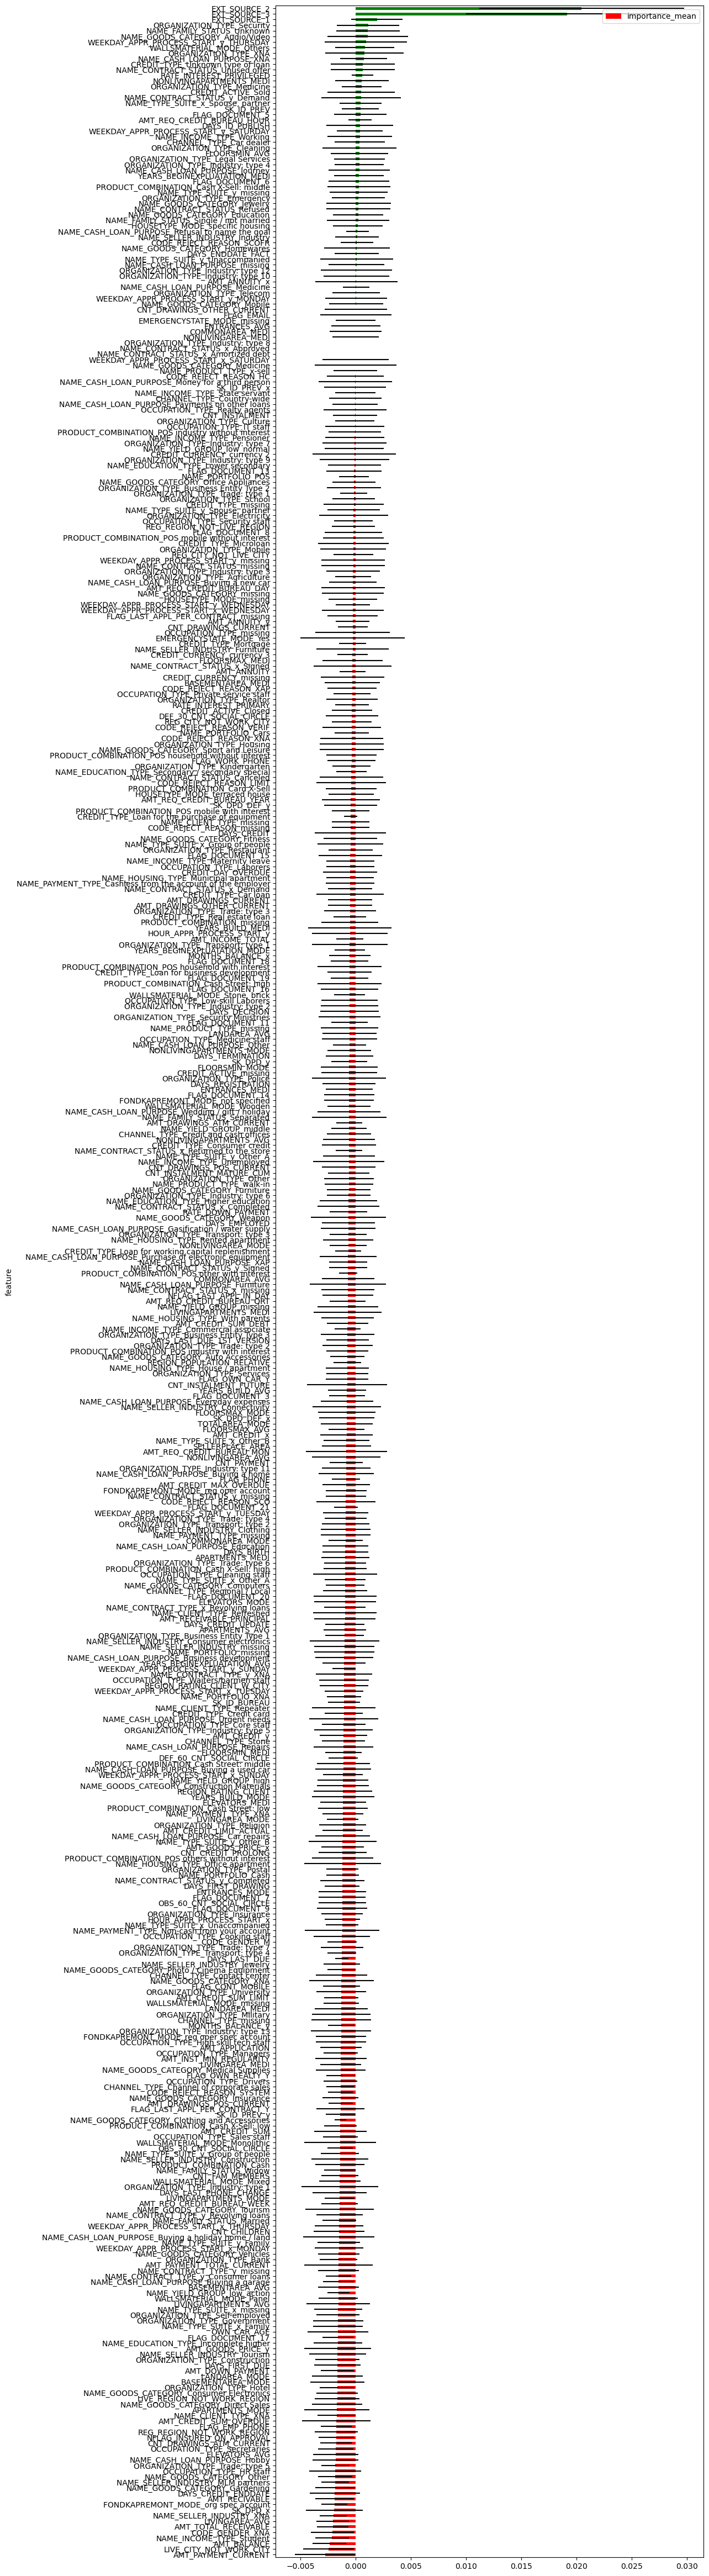

In [139]:
plot_importance(importance_df, figsize=(10, 60))

In [291]:
important_features = importance_df.sort_values(by='importance_mean', ascending=False)['feature'].tolist()

important_features = important_features[:-50]
print(len(important_features))

408


In [292]:
important_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'ORGANIZATION_TYPE_Security',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_GOODS_CATEGORY_Audio/Video',
 'WEEKDAY_APPR_PROCESS_START_y_THURSDAY',
 'WALLSMATERIAL_MODE_Others',
 'ORGANIZATION_TYPE_XNA',
 'NAME_CASH_LOAN_PURPOSE_XNA',
 'CREDIT_TYPE_Unknown type of loan',
 'NAME_CONTRACT_STATUS_Unused offer',
 'RATE_INTEREST_PRIVILEGED',
 'NONLIVINGAPARTMENTS_MEDI',
 'ORGANIZATION_TYPE_Medicine',
 'CREDIT_ACTIVE_Sold',
 'NAME_CONTRACT_STATUS_y_Demand',
 'NAME_TYPE_SUITE_x_Spouse, partner',
 'SK_ID_PREV',
 'FLAG_DOCUMENT_5',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'DAYS_ID_PUBLISH',
 'WEEKDAY_APPR_PROCESS_START_y_SATURDAY',
 'NAME_INCOME_TYPE_Working',
 'CHANNEL_TYPE_Car dealer',
 'ORGANIZATION_TYPE_Cleaning',
 'FLOORSMIN_AVG',
 'ORGANIZATION_TYPE_Legal Services',
 'ORGANIZATION_TYPE_Industry: type 4',
 'NAME_CASH_LOAN_PURPOSE_Journey',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLAG_DOCUMENT_6',
 'PRODUCT_COMBINATION_Cash X-Sell: middle',
 'NAME_TYPE_SUITE_y_m

In [26]:
important_features= ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'ORGANIZATION_TYPE_Security',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_GOODS_CATEGORY_Audio/Video',
 'WEEKDAY_APPR_PROCESS_START_y_THURSDAY',
 'WALLSMATERIAL_MODE_Others',
 'ORGANIZATION_TYPE_XNA',
 'NAME_CASH_LOAN_PURPOSE_XNA',
 'CREDIT_TYPE_Unknown type of loan',
 'NAME_CONTRACT_STATUS_Unused offer',
 'RATE_INTEREST_PRIVILEGED',
 'NONLIVINGAPARTMENTS_MEDI',
 'ORGANIZATION_TYPE_Medicine',
 'CREDIT_ACTIVE_Sold',
 'NAME_CONTRACT_STATUS_y_Demand',
 'NAME_TYPE_SUITE_x_Spouse, partner',
 'SK_ID_PREV',
 'FLAG_DOCUMENT_5',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'DAYS_ID_PUBLISH',
 'WEEKDAY_APPR_PROCESS_START_y_SATURDAY',
 'NAME_INCOME_TYPE_Working',
 'CHANNEL_TYPE_Car dealer',
 'ORGANIZATION_TYPE_Cleaning',
 'FLOORSMIN_AVG',
 'ORGANIZATION_TYPE_Legal Services',
 'ORGANIZATION_TYPE_Industry: type 4',
 'NAME_CASH_LOAN_PURPOSE_Journey',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLAG_DOCUMENT_6',
 'PRODUCT_COMBINATION_Cash X-Sell: middle',
 'NAME_TYPE_SUITE_y_missing',
 'ORGANIZATION_TYPE_Emergency',
 'NAME_GOODS_CATEGORY_Jewelry',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_GOODS_CATEGORY_Education',
 'NAME_FAMILY_STATUS_Single / not married',
 'HOUSETYPE_MODE_specific housing',
 'NAME_CASH_LOAN_PURPOSE_Refusal to name the goal',
 'NAME_SELLER_INDUSTRY_Industry',
 'CODE_REJECT_REASON_SCOFR',
 'NAME_GOODS_CATEGORY_Homewares',
 'DAYS_ENDDATE_FACT',
 'NAME_TYPE_SUITE_y_Unaccompanied',
 'NAME_CASH_LOAN_PURPOSE_missing',
 'ORGANIZATION_TYPE_Industry: type 12',
 'ORGANIZATION_TYPE_Industry: type 10',
 'AMT_ANNUITY_x',
 'NAME_CASH_LOAN_PURPOSE_Medicine',
 'ORGANIZATION_TYPE_Telecom',
 'WEEKDAY_APPR_PROCESS_START_y_MONDAY',
 'NAME_GOODS_CATEGORY_Mobile',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'FLAG_EMAIL',
 'EMERGENCYSTATE_MODE_missing',
 'ENTRANCES_AVG',
 'COMMONAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'ORGANIZATION_TYPE_Industry: type 8',
 'NAME_CONTRACT_STATUS_x_Approved',
 'NAME_CONTRACT_STATUS_x_Amortized debt',
 'WEEKDAY_APPR_PROCESS_START_x_SATURDAY',
 'NAME_GOODS_CATEGORY_Medicine',
 'NAME_PRODUCT_TYPE_x-sell',
 'CODE_REJECT_REASON_HC',
 'NAME_CASH_LOAN_PURPOSE_Money for a third person',
 'SK_ID_PREV_x',
 'NAME_INCOME_TYPE_State servant',
 'CHANNEL_TYPE_Country-wide',
 'NAME_CASH_LOAN_PURPOSE_Payments on other loans',
 'OCCUPATION_TYPE_Realty agents',
 'CNT_INSTALMENT',
 'ORGANIZATION_TYPE_Culture',
 'OCCUPATION_TYPE_IT staff',
 'PRODUCT_COMBINATION_POS industry without interest',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_Industry: type 7',
 'NAME_YIELD_GROUP_low_normal',
 'CREDIT_CURRENCY_currency 2',
 'ORGANIZATION_TYPE_Industry: type 9',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'FLAG_DOCUMENT_13',
 'NAME_PORTFOLIO_POS',
 'NAME_GOODS_CATEGORY_Office Appliances',
 'ORGANIZATION_TYPE_Business Entity Type 2',
 'ORGANIZATION_TYPE_Trade: type 1',
 'ORGANIZATION_TYPE_School',
 'CREDIT_TYPE_missing',
 'NAME_TYPE_SUITE_y_Spouse, partner',
 'ORGANIZATION_TYPE_Electricity',
 'OCCUPATION_TYPE_Security staff',
 'REG_REGION_NOT_LIVE_REGION',
 'FLAG_DOCUMENT_8',
 'PRODUCT_COMBINATION_POS mobile without interest',
 'CREDIT_TYPE_Microloan',
 'ORGANIZATION_TYPE_Mobile',
 'REG_CITY_NOT_LIVE_CITY',
 'NAME_CONTRACT_STATUS_missing',
 'WEEKDAY_APPR_PROCESS_START_y_missing',
 'ORGANIZATION_TYPE_Industry: type 3',
 'ORGANIZATION_TYPE_Agriculture',
 'NAME_CASH_LOAN_PURPOSE_Buying a new car',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'NAME_GOODS_CATEGORY_missing',
 'HOUSETYPE_MODE_missing',
 'WEEKDAY_APPR_PROCESS_START_y_WEDNESDAY',
 'WEEKDAY_APPR_PROCESS_START_x_WEDNESDAY',
 'FLAG_LAST_APPL_PER_CONTRACT_missing',
 'AMT_ANNUITY_y',
 'CNT_DRAWINGS_CURRENT',
 'OCCUPATION_TYPE_missing',
 'EMERGENCYSTATE_MODE_Yes',
 'CREDIT_TYPE_Mortgage',
 'NAME_SELLER_INDUSTRY_Furniture',
 'CREDIT_CURRENCY_currency 3',
 'FLOORSMAX_MEDI',
 'NAME_CONTRACT_STATUS_x_Signed',
 'AMT_ANNUITY',
 'CREDIT_CURRENCY_missing',
 'BASEMENTAREA_MEDI',
 'CODE_REJECT_REASON_XAP',
 'OCCUPATION_TYPE_Private service staff',
 'ORGANIZATION_TYPE_Realtor',
 'RATE_INTEREST_PRIMARY',
 'CREDIT_ACTIVE_Closed',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'REG_CITY_NOT_WORK_CITY',
 'CODE_REJECT_REASON_VERIF',
 'NAME_PORTFOLIO_Cars',
 'CODE_REJECT_REASON_XNA',
 'ORGANIZATION_TYPE_Housing',
 'NAME_GOODS_CATEGORY_Sport and Leisure',
 'PRODUCT_COMBINATION_POS household without interest',
 'FLAG_WORK_PHONE',
 'ORGANIZATION_TYPE_Kindergarten',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_CONTRACT_STATUS_Canceled',
 'CODE_REJECT_REASON_LIMIT',
 'PRODUCT_COMBINATION_Card X-Sell',
 'HOUSETYPE_MODE_terraced house',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'SK_DPD_DEF_y',
 'PRODUCT_COMBINATION_POS mobile with interest',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'NAME_CLIENT_TYPE_missing',
 'CODE_REJECT_REASON_missing',
 'DAYS_CREDIT',
 'NAME_GOODS_CATEGORY_Fitness',
 'NAME_TYPE_SUITE_x_Group of people',
 'ORGANIZATION_TYPE_Restaurant',
 'FLAG_DOCUMENT_15',
 'NAME_INCOME_TYPE_Maternity leave',
 'OCCUPATION_TYPE_Laborers',
 'CREDIT_DAY_OVERDUE',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_PAYMENT_TYPE_Cashless from the account of the employer',
 'NAME_CONTRACT_STATUS_x_Demand',
 'CREDIT_TYPE_Car loan',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'ORGANIZATION_TYPE_Trade: type 3',
 'CREDIT_TYPE_Real estate loan',
 'PRODUCT_COMBINATION_missing',
 'YEARS_BUILD_MEDI',
 'HOUR_APPR_PROCESS_START_y',
 'AMT_INCOME_TOTAL',
 'ORGANIZATION_TYPE_Transport: type 1',
 'YEARS_BEGINEXPLUATATION_MODE',
 'MONTHS_BALANCE_x',
 'FLAG_DOCUMENT_18',
 'PRODUCT_COMBINATION_POS household with interest',
 'CREDIT_TYPE_Loan for business development',
 'FLAG_DOCUMENT_19',
 'PRODUCT_COMBINATION_Cash Street: high',
 'FLAG_DOCUMENT_16',
 'WALLSMATERIAL_MODE_Stone, brick',
 'OCCUPATION_TYPE_Low-skill Laborers',
 'ORGANIZATION_TYPE_Industry: type 2',
 'DAYS_DECISION',
 'ORGANIZATION_TYPE_Security Ministries',
 'FLAG_DOCUMENT_11',
 'NAME_PRODUCT_TYPE_missing',
 'LANDAREA_AVG',
 'OCCUPATION_TYPE_Medicine staff',
 'NAME_CASH_LOAN_PURPOSE_Other',
 'NONLIVINGAPARTMENTS_MODE',
 'DAYS_TERMINATION',
 'SK_DPD_y',
 'FLOORSMIN_MODE',
 'CREDIT_ACTIVE_missing',
 'ORGANIZATION_TYPE_Police',
 'DAYS_REGISTRATION',
 'ENTRANCES_MEDI',
 'FLAG_DOCUMENT_14',
 'FONDKAPREMONT_MODE_not specified',
 'WALLSMATERIAL_MODE_Wooden',
 'NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday',
 'NAME_FAMILY_STATUS_Separated',
 'AMT_DRAWINGS_ATM_CURRENT',
 'NAME_YIELD_GROUP_middle',
 'CHANNEL_TYPE_Credit and cash offices',
 'NONLIVINGAPARTMENTS_AVG',
 'CREDIT_TYPE_Consumer credit',
 'NAME_CONTRACT_STATUS_x_Returned to the store',
 'NAME_TYPE_SUITE_y_Other_A',
 'NAME_INCOME_TYPE_Unemployed',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'ORGANIZATION_TYPE_Other',
 'NAME_PRODUCT_TYPE_walk-in',
 'NAME_GOODS_CATEGORY_Furniture',
 'ORGANIZATION_TYPE_Industry: type 6',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_CONTRACT_STATUS_x_Completed',
 'RATE_DOWN_PAYMENT',
 'NAME_GOODS_CATEGORY_Weapon',
 'DAYS_EMPLOYED',
 'NAME_CASH_LOAN_PURPOSE_Gasification / water supply',
 'ORGANIZATION_TYPE_Transport: type 3',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NONLIVINGAREA_MODE',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment',
 'NAME_CASH_LOAN_PURPOSE_XAP',
 'NAME_CONTRACT_STATUS_y_Signed',
 'PRODUCT_COMBINATION_POS other with interest',
 'COMMONAREA_AVG',
 'NAME_CASH_LOAN_PURPOSE_Furniture',
 'NAME_CONTRACT_STATUS_x_missing',
 'NFLAG_LAST_APPL_IN_DAY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_YIELD_GROUP_missing',
 'LIVINGAPARTMENTS_MEDI',
 'NAME_HOUSING_TYPE_With parents',
 'AMT_CREDIT_SUM_DEBT',
 'NAME_INCOME_TYPE_Commercial associate',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'DAYS_LAST_DUE_1ST_VERSION',
 'ORGANIZATION_TYPE_Trade: type 2',
 'PRODUCT_COMBINATION_POS industry with interest',
 'NAME_GOODS_CATEGORY_Auto Accessories',
 'REGION_POPULATION_RELATIVE',
 'NAME_HOUSING_TYPE_House / apartment',
 'ORGANIZATION_TYPE_Services',
 'FLAG_OWN_CAR_Y',
 'CNT_INSTALMENT_FUTURE',
 'YEARS_BUILD_AVG',
 'FLAG_DOCUMENT_3',
 'NAME_CASH_LOAN_PURPOSE_Everyday expenses',
 'NAME_SELLER_INDUSTRY_Connectivity',
 'FLOORSMAX_MODE',
 'SK_DPD_DEF_x',
 'TOTALAREA_MODE',
 'FLOORSMAX_AVG',
 'AMT_CREDIT_x',
 'NAME_TYPE_SUITE_x_Other_B',
 'SELLERPLACE_AREA',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'NONLIVINGAREA_AVG',
 'CNT_PAYMENT',
 'ORGANIZATION_TYPE_Industry: type 11',
 'NAME_CASH_LOAN_PURPOSE_Buying a home',
 'FLAG_PHONE',
 'AMT_CREDIT_MAX_OVERDUE',
 'FONDKAPREMONT_MODE_reg oper account',
 'NAME_CONTRACT_STATUS_y_missing',
 'CODE_REJECT_REASON_SCO',
 'FLAG_DOCUMENT_21',
 'WEEKDAY_APPR_PROCESS_START_y_TUESDAY',
 'ORGANIZATION_TYPE_Trade: type 4',
 'ORGANIZATION_TYPE_Transport: type 2',
 'NAME_SELLER_INDUSTRY_Clothing',
 'NAME_PAYMENT_TYPE_missing',
 'COMMONAREA_MODE',
 'NAME_CASH_LOAN_PURPOSE_Education',
 'DAYS_BIRTH',
 'APARTMENTS_MEDI',
 'ORGANIZATION_TYPE_Trade: type 6',
 'PRODUCT_COMBINATION_Cash X-Sell: high',
 'OCCUPATION_TYPE_Cleaning staff',
 'NAME_TYPE_SUITE_x_Other_A',
 'NAME_GOODS_CATEGORY_Computers',
 'CHANNEL_TYPE_Regional / Local',
 'FLAG_DOCUMENT_20',
 'ELEVATORS_MODE',
 'NAME_CONTRACT_TYPE_x_Revolving loans',
 'NAME_CLIENT_TYPE_Refreshed',
 'AMT_RECEIVABLE_PRINCIPAL',
 'DAYS_CREDIT_UPDATE',
 'APARTMENTS_AVG',
 'ORGANIZATION_TYPE_Business Entity Type 1',
 'NAME_SELLER_INDUSTRY_Consumer electronics',
 'NAME_SELLER_INDUSTRY_missing',
 'NAME_PORTFOLIO_missing',
 'NAME_CASH_LOAN_PURPOSE_Business development',
 'YEARS_BEGINEXPLUATATION_AVG',
 'WEEKDAY_APPR_PROCESS_START_y_SUNDAY',
 'NAME_CONTRACT_TYPE_y_XNA',
 'OCCUPATION_TYPE_Waiters/barmen staff',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x_TUESDAY',
 'NAME_PORTFOLIO_XNA',
 'SK_ID_BUREAU',
 'NAME_CLIENT_TYPE_Repeater',
 'CREDIT_TYPE_Credit card',
 'NAME_CASH_LOAN_PURPOSE_Urgent needs',
 'OCCUPATION_TYPE_Core staff',
 'ORGANIZATION_TYPE_Industry: type 5',
 'AMT_CREDIT_y',
 'CHANNEL_TYPE_Stone',
 'NAME_CASH_LOAN_PURPOSE_Repairs',
 'FLOORSMIN_MEDI',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'PRODUCT_COMBINATION_Cash Street: middle',
 'NAME_CASH_LOAN_PURPOSE_Buying a used car',
 'WEEKDAY_APPR_PROCESS_START_x_SUNDAY',
 'NAME_YIELD_GROUP_high',
 'NAME_GOODS_CATEGORY_Construction Materials',
 'REGION_RATING_CLIENT',
 'YEARS_BUILD_MODE',
 'ELEVATORS_MEDI',
 'PRODUCT_COMBINATION_Cash Street: low',
 'NAME_PAYMENT_TYPE_XNA',
 'LIVINGAREA_MODE',
 'ORGANIZATION_TYPE_Religion',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'NAME_CASH_LOAN_PURPOSE_Car repairs',
 'NAME_TYPE_SUITE_y_Other_B',
 'AMT_GOODS_PRICE_x',
 'CNT_CREDIT_PROLONG',
 'PRODUCT_COMBINATION_POS others without interest',
 'NAME_HOUSING_TYPE_Office apartment',
 'ORGANIZATION_TYPE_Postal',
 'NAME_PORTFOLIO_Cash',
 'NAME_CONTRACT_STATUS_y_Completed',
 'DAYS_FIRST_DRAWING',
 'ENTRANCES_MODE',
 'FLAG_DOCUMENT_7',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_9',
 'ORGANIZATION_TYPE_Insurance',
 'HOUR_APPR_PROCESS_START_x',
 'NAME_TYPE_SUITE_x_Unaccompanied',
 'NAME_PAYMENT_TYPE_Non-cash from your account',
 'OCCUPATION_TYPE_Cooking staff',
 'CODE_GENDER_M',
 'ORGANIZATION_TYPE_Trade: type 7',
 'ORGANIZATION_TYPE_Transport: type 4',
 'DAYS_LAST_DUE',
 'NAME_SELLER_INDUSTRY_Jewelry',
 'NAME_GOODS_CATEGORY_Photo / Cinema Equipment',
 'CHANNEL_TYPE_Contact center',
 'NAME_GOODS_CATEGORY_XNA',
 'FLAG_CONT_MOBILE',
 'ORGANIZATION_TYPE_University',
 'AMT_CREDIT_SUM_LIMIT',
 'WALLSMATERIAL_MODE_missing',
 'LANDAREA_MEDI',
 'ORGANIZATION_TYPE_Military',
 'CHANNEL_TYPE_missing',
 'MONTHS_BALANCE_y',
 'ORGANIZATION_TYPE_Industry: type 13',
 'FONDKAPREMONT_MODE_reg oper spec account',
 'OCCUPATION_TYPE_High skill tech staff',
 'AMT_APPLICATION',
 'OCCUPATION_TYPE_Managers',
 'AMT_INST_MIN_REGULARITY',
 'LIVINGAREA_MEDI',
 'NAME_GOODS_CATEGORY_Medical Supplies',
 'FLAG_OWN_REALTY_Y',
 'OCCUPATION_TYPE_Drivers',
 'CHANNEL_TYPE_Channel of corporate sales',
 'CODE_REJECT_REASON_SYSTEM',
 'NAME_GOODS_CATEGORY_Insurance',
 'AMT_DRAWINGS_POS_CURRENT',
 'FLAG_LAST_APPL_PER_CONTRACT_Y',
 'SK_ID_PREV_y',
 'NAME_GOODS_CATEGORY_Clothing and Accessories',
 'PRODUCT_COMBINATION_Cash X-Sell: low',
 'AMT_CREDIT_SUM',
 'OCCUPATION_TYPE_Sales staff',
 'WALLSMATERIAL_MODE_Monolithic',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'NAME_TYPE_SUITE_y_Group of people',
 'NAME_SELLER_INDUSTRY_Construction',
 'PRODUCT_COMBINATION_Cash',
 'NAME_FAMILY_STATUS_Widow',
 'CNT_FAM_MEMBERS',
 'WALLSMATERIAL_MODE_Mixed',
 'ORGANIZATION_TYPE_Industry: type 1',
 'DAYS_LAST_PHONE_CHANGE',
 'LIVINGAPARTMENTS_MODE',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'NAME_GOODS_CATEGORY_Tourism',
 'NAME_CONTRACT_TYPE_y_Revolving loans',
 'NAME_FAMILY_STATUS_Married',
 'WEEKDAY_APPR_PROCESS_START_x_THURSDAY',
 'CNT_CHILDREN',
 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land',
 'NAME_TYPE_SUITE_y_Family',
 'WEEKDAY_APPR_PROCESS_START_x_MONDAY',
 'NAME_GOODS_CATEGORY_Vehicles',
 'ORGANIZATION_TYPE_Bank',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'NAME_CONTRACT_TYPE_y_missing',
 'NAME_CONTRACT_TYPE_y_Consumer loans']

In [27]:
X_train_important = X_train_encoded[important_features]
X_valid_important = X_valid_encoded[important_features]

In [294]:
catboost_model = CatBoostClassifier(iterations=100,
                              learning_rate=0.1,
                              depth=7,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              random_seed=17,
                              allow_writing_files=False
                              )

In [295]:
import re
def clean_column_names(columns):
    cleaned_columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in columns]
    return cleaned_columns

# Özellik adlarını temizleme
X_train_important.columns = clean_column_names(X_train_important.columns)
X_valid_important.columns = clean_column_names(X_valid_important.columns)

# Modeli yeniden eğitme
catboost_model.fit(X_train_important, y_train)


0:	total: 399ms	remaining: 39.5s
50:	total: 17.4s	remaining: 16.7s
99:	total: 31.1s	remaining: 0us


In [296]:
scores = cross_val_score(catboost_model, X_train_important, y_train, cv=skf, scoring='roc_auc')

print("Cross-Validation Mean ROC-AUC Score:", scores.mean())

0:	total: 270ms	remaining: 26.8s
50:	total: 13.7s	remaining: 13.2s
99:	total: 26.1s	remaining: 0us
0:	total: 908ms	remaining: 1m 29s
50:	total: 13.8s	remaining: 13.2s
99:	total: 27.3s	remaining: 0us
0:	total: 271ms	remaining: 26.8s
50:	total: 15.2s	remaining: 14.6s
99:	total: 29.9s	remaining: 0us
0:	total: 317ms	remaining: 31.4s
50:	total: 12.3s	remaining: 11.8s
99:	total: 24.4s	remaining: 0us
0:	total: 276ms	remaining: 27.4s
50:	total: 12.9s	remaining: 12.4s
99:	total: 25.4s	remaining: 0us
Cross-Validation Mean ROC-AUC Score: 0.7688027656930752


#### OPTUNA

In [300]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**param, verbose=0)
    scores = cross_val_score(model, X_train_important, y_train, cv=skf, scoring='roc_auc')
    return scores.mean()

In [302]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-09-02 10:21:44,874] A new study created in memory with name: no-name-e53ad91d-1936-48ee-88af-897e0d158c29
[I 2024-09-02 10:40:03,392] Trial 0 finished with value: 0.7728384264582868 and parameters: {'iterations': 824, 'depth': 10, 'learning_rate': 0.023784045591385694, 'random_strength': 29, 'bagging_temperature': 0.884783322358536, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 0 with value: 0.7728384264582868.
[I 2024-09-02 10:43:26,216] Trial 1 finished with value: 0.7772162307135714 and parameters: {'iterations': 888, 'depth': 3, 'learning_rate': 0.119617147997465, 'random_strength': 58, 'bagging_temperature': 0.5524711018726204, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 1 with value: 0.7772162307135714.
[I 2024-09-02 10:48:08,255] Trial 2 finished with value: 0.7715751687459693 and parameters: {'iterations': 995, 'depth': 5, 'learning_rate': 0.21023457407186022, 'random_strength': 59, 'bagging_temperature': 0.7411219080701642, 'od_type': 'IncToDec', 'od_wait':

Number of finished trials: 20
Best trial: {'iterations': 863, 'depth': 4, 'learning_rate': 0.1209950473910379, 'random_strength': 41, 'bagging_temperature': 0.11507134288935156, 'od_type': 'IncToDec', 'od_wait': 25}


In [35]:
best_trial_params = {
         'iterations': 863,
         'depth': 4,
         'learning_rate': 0.1209950473910379,
         'random_strength': 41,
         'bagging_temperature': 0.11507134288935156,
         'od_type': 'IncToDec',
         'od_wait': 25}

In [37]:
model = CatBoostClassifier(**best_trial_params, verbose=0)

# Evaluate the model
scores = cross_val_score(model, X_train_important, y_train, scoring='roc_auc', cv=skf)
print("Mean ROC AUC Scores with best parameters:", scores.mean())

Mean ROC AUC Scores with best parameters: 0.7776925912097804


In [38]:
model.fit(X_train_important, y_train)

#### SHAP

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_important)

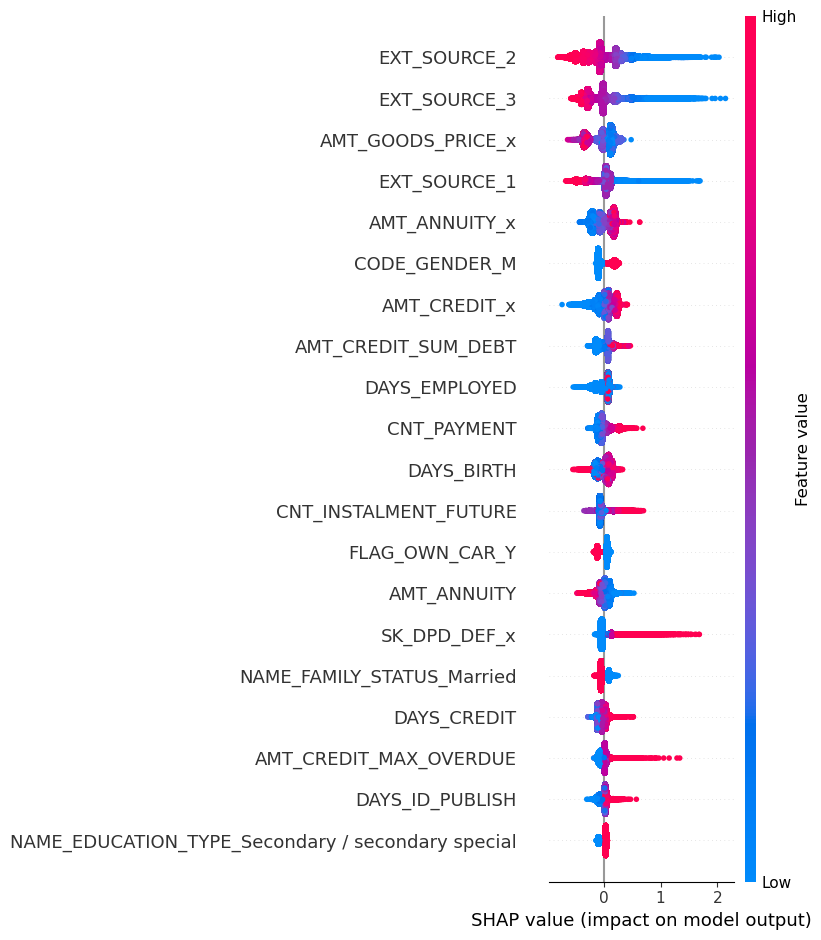

In [40]:
shap.summary_plot(shap_values, X_train_important)
